In [1]:
import string
import torch
from torch import nn
import os
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
from random import sample
plt.style.use('dark_background')

In [29]:
import wget
wget.download('https://raw.githubusercontent.com/attatrol/data_sources/master/onegin.txt')

100% [............................................................................] 262521 / 262521

'onegin (1).txt'

In [30]:
with open('onegin.txt', 'r', encoding="utf8") as iofile:
    text = iofile.readlines()
    
text = [x.replace('\t\t', '') for x in text]

whole_text = ""

for strin in text:
    whole_text += strin
text = whole_text.lower()

In [3]:
with open('sonnets.txt', 'r') as iofile:
    text = iofile.readlines()
    
TEXT_START = 45
TEXT_END = -368
text = text[TEXT_START : TEXT_END]
assert len(text) == 2616

whole_text = ""

for strin in text:
    whole_text += strin
text = whole_text.lower()

assert len(text) == 100225, 'Are you sure you have concatenated all the strings?'
assert not any([x in set(text) for x in string.ascii_uppercase]), 'Uppercase letters are present'
print('OK!')

OK!


In [31]:
text

'\ni\n\n«мой дядя самых честных правил,\nкогда не в шутку занемог,\nон уважать себя заставил\nи лучше выдумать не мог.\nего пример другим наука;\nно, боже мой, какая скука\nс больным сидеть и день и ночь,\nне отходя ни шагу прочь!\nкакое низкое коварство\nполуживого забавлять,\nему подушки поправлять,\nпечально подносить лекарство,\nвздыхать и думать про себя:\nкогда же черт возьмет тебя!»\n\n\n\nii\n\nтак думал молодой повеса,\nлетя в пыли на почтовых,\nвсевышней волею зевеса\nнаследник всех своих родных. —\nдрузья людмилы и руслана!\nс героем моего романа\nбез предисловий, сей же час\nпозвольте познакомить вас:\nонегин, добрый мой приятель,\nродился на брегах невы,\nгде, может быть, родились вы\nили блистали, мой читатель;\nтам некогда гулял и я:\nно вреден север для меня\n\n\niii\n\nслужив отлично-благородно,\nдолгами жил его отец,\nдавал три бала ежегодно\nи промотался наконец.\nсудьба евгения хранила:\nсперва madame за ним ходила,\nпотом monsieur ее сменил;\nребенок был резов, но 

max length = 158


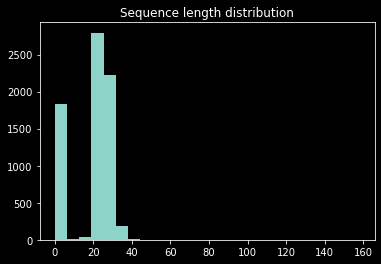

In [3]:
lines = text.split('\n')

MAX_LENGTH = max(map(len, lines))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, lines)),bins=25);

max length = 40


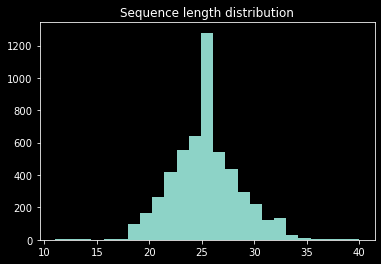

In [5]:
i = 0
len_of_list = len(lines)
while i < len_of_list:
    if len(lines[i]) < 11 or len(lines[i]) > 40:
        lines.remove(lines[i])
        len_of_list = len(lines)
        i-=1
    i+=1
    
MAX_LENGTH = max(map(len, lines))
print("max length =", MAX_LENGTH)

plt.title('Sequence length distribution')
plt.hist(list(map(len, lines)),bins=25);

In [8]:
text

'«мой дядя самых честных правил,\n когда не в шутку занемог,\n он уважать себя заставил\n и лучше выдумать не мог.\n его пример другим наука;\n но, боже мой, какая скука\n с больным сидеть и день и ночь,\n не отходя ни шагу прочь!\n какое низкое коварство\n полуживого забавлять,\n ему подушки поправлять,\n печально подносить лекарство,\n вздыхать и думать про себя:\n когда же черт возьмет тебя!»\n так думал молодой повеса,\n летя в пыли на почтовых,\n всевышней волею зевеса\n наследник всех своих родных. —\n друзья людмилы и руслана!\n с героем моего романа\n без предисловий, сей же час\n позвольте познакомить вас:\n онегин, добрый мой приятель,\n родился на брегах невы,\n где, может быть, родились вы\n или блистали, мой читатель;\n там некогда гулял и я:\n но вреден север для меня\n служив отлично-благородно,\n долгами жил его отец,\n давал три бала ежегодно\n и промотался наконец.\n судьба евгения хранила:\n сперва madame за ним ходила,\n потом monsieur ее сменил;\n ребенок был резов

In [7]:
text = ''
for k in lines:
    text=text + k +'\n '

In [32]:
class Model(nn.Module):
    def __init__(self, dataset):
        super(Model, self).__init__()
        self.lstm_size = 400
        self.embedding_dim = 200
        self.num_layers = 3
        n_vocab = len(dataset.uniq_words)
        self.embedding = nn.Embedding(num_embeddings=n_vocab, embedding_dim=self.embedding_dim,)
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state
    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))

In [40]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, text):
        self.seq_len = 5
        self.max_epochs = 50
        self.text = text
        self.words = self.load_words()
        self.uniq_words = self.get_uniq_words()
        self.index_to_word = {index: word for index, word in enumerate(self.uniq_words)}
        self.word_to_index = {word: index for index, word in enumerate(self.uniq_words)}
        self.words_indexes = [self.word_to_index[w] for w in self.words]
    def load_words(self):
        inp = self.text.split(' ')
        out = ''
        for word in inp:
            if (word != '\n') and (word != ''):
                out = out + word + ' '
            elif word == '\n':
                out+='\n'
        return out.split(' ')
    def get_uniq_words(self):
        word_counts = Counter(self.words)
        return sorted(word_counts, key=word_counts.get, reverse=True)
    def __len__(self):
        return len(self.words_indexes) - self.seq_len
    def __getitem__(self, index):
        return (
            torch.tensor(self.words_indexes[index:index+self.seq_len]),
            torch.tensor(self.words_indexes[index+1:index+self.seq_len+1]),
        )

In [38]:
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from collections import Counter

def train(dataset, model, device = device):
    seq_len = 5
    max_epochs = 50
    model.train()
    dataloader = DataLoader(dataset, batch_size=256)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(max_epochs):
        state_h, state_c = model.init_state(seq_len)
        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            y_pred, (state_h, state_c) = model(x.to(device), (state_h.to(device), state_c.to(device)))
            loss = criterion(y_pred.transpose(1, 2), y.to(device))
            state_h = state_h.detach()
            state_c = state_c.detach()
            loss.backward()
            optimizer.step()
        print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })

In [9]:
def predict(dataset, model, text, next_words=100, temperature=1.0):
    model.eval()
    words = text.split(' ')
    state_h, state_c = model.init_state(len(words))
    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in words[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))
        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits/temperature, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
        words.append(dataset.index_to_word[word_index])
        text= text + ' ' + dataset.index_to_word[word_index]
    return text

In [41]:
# import argparse
# parser = argparse.ArgumentParser()
# parser.add_argument('--max-epochs', type=int, default=10)
# parser.add_argument('--batch-size', type=int, default=256)
# parser.add_argument('--sequence-length', type=int, default=4)
# args = parser.parse_args()
dataset = Dataset(text)
model = Model(dataset)
model.to(device)
train(dataset, model)

{'epoch': 0, 'batch': 67, 'loss': 9.015096664428711}
{'epoch': 1, 'batch': 67, 'loss': 8.514669418334961}
{'epoch': 2, 'batch': 67, 'loss': 8.368385314941406}
{'epoch': 3, 'batch': 67, 'loss': 8.294075965881348}
{'epoch': 4, 'batch': 67, 'loss': 8.262619018554688}
{'epoch': 5, 'batch': 67, 'loss': 8.243743896484375}
{'epoch': 6, 'batch': 67, 'loss': 8.232885360717773}
{'epoch': 7, 'batch': 67, 'loss': 8.225024223327637}
{'epoch': 8, 'batch': 67, 'loss': 8.219566345214844}
{'epoch': 9, 'batch': 67, 'loss': 8.216282844543457}
{'epoch': 10, 'batch': 67, 'loss': 8.213261604309082}
{'epoch': 11, 'batch': 67, 'loss': 8.211275100708008}
{'epoch': 12, 'batch': 67, 'loss': 8.209580421447754}
{'epoch': 13, 'batch': 67, 'loss': 8.20869255065918}
{'epoch': 14, 'batch': 67, 'loss': 8.37252140045166}
{'epoch': 15, 'batch': 67, 'loss': 8.587294578552246}
{'epoch': 16, 'batch': 67, 'loss': 8.479508399963379}
{'epoch': 17, 'batch': 67, 'loss': 8.38392448425293}
{'epoch': 18, 'batch': 67, 'loss': 8.3210

In [36]:
def save_checkpoint(path, model):
    state = {'state_dict': model.state_dict()}
    torch.save(state, path)
    print('model saved to %s' % path)
    
def load_checkpoint(path, model):
    state = torch.load(path)
    model.load_state_dict(state['state_dict'])
    print('model loaded from %s' % path)

In [37]:
save_checkpoint("LSTM_Sonet_30epoch.pth", model)

model saved to LSTM_Sonet_30epoch.pth


In [58]:
model_two = Model(dataset)
load_checkpoint("LSTM.pth", model_two)

model loaded from LSTM.pth


In [59]:
model.to('cpu')
print(predict(dataset, model, text='ленский', temperature = 1.0))

ленский полна,
остановилася устах.



xi

мой тайные найдено?
часы где тихо одежде к шевельнулась;
не наши и незапный совет:
отстать не верно минувших злобному блещут не ты, счастьем лета,
забудет боярский стрелой
взлетел удивления, не подъезжает долинах,
весной, пугал прости!



l

прости (шишков, шутивший:
отменно и он свежеют,
и как я вольность след…



xxxiv

да, затей…
всё мельмотом,
космополитом, желанья,
что – мог
того, свете.
постой, я пор,
то далеко;
мечты, лежит,
и и света дел,
ничем и синих, валов,
хвалебный подымет шлют всё ж журналы,
где радость,
не татьяна
и талом век малость!
как молодою,
и и ним,
как меня было меня ложь удивления, тани
вы делится – толкнули,
и взглядом!..
но как аллей,
туда, ворот но игру он подносить и вас; читает
и благодарна труд, грязно всё без взор
ему роскоши, на лукавить?),
но человек
изображен в дубов;
легла


In [10]:
import torch.onnx
device = torch.device("cuda")

In [37]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, text):
        self.text = text
        self.seq_len = 100
        self.max_epochs = 20
        self.chars = self.load_chars()
        self.index_to_word = {index: word for index, word in enumerate(self.chars)}
        self.word_to_index = {word: index for index, word in enumerate(self.chars)}
        self.max_len = (len(text) - 1)//self.seq_len - 1
#         self.words_indexes = [self.word_to_index[w] for w in self.words]
    def load_chars(self):
        return sorted(list(set(self.text)))
    
    def to_matrix(self, line, dtype='int32'):
        """Casts a list of names into rnn-digestable matrix"""
        
        names_ix = np.zeros(self.max_len, dtype) + self.word_to_index[' ']
        names_ix = [self.word_to_index[c] for c in line]
        return names_ix

    def __len__(self):
        return (len(self.text) - 1)//self.seq_len - 1
    def __getitem__(self, index):
        return (
            torch.tensor(self.to_matrix(self.text[index*self.seq_len : (index+1)*self.seq_len - 1])),
            torch.tensor(self.to_matrix(self.text[index*self.seq_len+1:(index+1)*self.seq_len])))

In [38]:
def train(dataset, model, device = device):
    seq_len = 100
    max_epochs = 20
    model.train()
    dataloader = DataLoader(dataset, batch_size=50)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    for epoch in range(max_epochs):
        state_h, state_c = model.init_state(seq_len-1)
        for batch, (x, y) in enumerate(dataloader):
            optimizer.zero_grad()
            y_pred, (state_h, state_c) = model(x.to(device), (state_h.to(device), state_c.to(device)))
            loss = criterion(y_pred.transpose(1, 2), y.to(device))
            state_h = state_h.detach()
            state_c = state_c.detach()
            loss.backward()
            optimizer.step()
        print({ 'epoch': epoch, 'batch': batch, 'loss': loss.item() })
#         print({ 'epoch': epoch, 'loss': loss.item() })

In [22]:
class Model(nn.Module):
    def __init__(self, dataset):
        super(Model, self).__init__()
        self.lstm_size = 700
        self.embedding_dim = 300
        self.num_layers = 3
        n_vocab = len(dataset.chars)
        self.embedding = nn.Embedding(num_embeddings=n_vocab, embedding_dim=self.embedding_dim,)
        self.lstm = nn.LSTM(
            input_size=self.embedding_dim,
            hidden_size=self.lstm_size,
            num_layers=self.num_layers,
            dropout=0.2,
        )
        self.fc = nn.Linear(self.lstm_size, n_vocab)
    def forward(self, x, prev_state):
        embed = self.embedding(x)
        output, state = self.lstm(embed, prev_state)
        logits = self.fc(output)
        return logits, state
    def init_state(self, sequence_length):
        return (torch.zeros(self.num_layers, sequence_length, self.lstm_size),
                torch.zeros(self.num_layers, sequence_length, self.lstm_size))

In [25]:
dataset_two = Dataset(text)
model_char = Model(dataset_two)

In [39]:
# dataset_two = Dataset(text)
# model_char = Model(dataset_two)
model_char.to(device)
train(dataset_two, model_char)

{'epoch': 0, 'batch': 28, 'loss': 0.09682273864746094}
{'epoch': 1, 'batch': 28, 'loss': 0.10240859538316727}
{'epoch': 2, 'batch': 28, 'loss': 0.08513367921113968}
{'epoch': 3, 'batch': 28, 'loss': 0.08738216757774353}
{'epoch': 4, 'batch': 28, 'loss': 0.09647074341773987}
{'epoch': 5, 'batch': 28, 'loss': 0.079768106341362}
{'epoch': 6, 'batch': 28, 'loss': 0.08387468010187149}
{'epoch': 7, 'batch': 28, 'loss': 0.08808144927024841}
{'epoch': 8, 'batch': 28, 'loss': 0.07524663954973221}
{'epoch': 9, 'batch': 28, 'loss': 0.08898662775754929}
{'epoch': 10, 'batch': 28, 'loss': 0.07335591316223145}
{'epoch': 11, 'batch': 28, 'loss': 0.06725605577230453}
{'epoch': 12, 'batch': 28, 'loss': 0.06719626486301422}
{'epoch': 13, 'batch': 28, 'loss': 0.07358170300722122}
{'epoch': 14, 'batch': 28, 'loss': 0.07715991884469986}
{'epoch': 15, 'batch': 28, 'loss': 0.07090272754430771}
{'epoch': 16, 'batch': 28, 'loss': 0.06342017650604248}
{'epoch': 17, 'batch': 28, 'loss': 0.06325935572385788}
{'ep

In [28]:
def predict(dataset, model, text, next_words=500, temperature=1.0):
    model.eval()
    
    state_h, state_c = model.init_state(len(text))
    for i in range(0, next_words):
        x = torch.tensor([[dataset.word_to_index[w] for w in text[i:]]])
        y_pred, (state_h, state_c) = model(x, (state_h, state_c))
        last_word_logits = y_pred[0][-1]
        p = torch.nn.functional.softmax(last_word_logits/temperature, dim=0).detach().numpy()
        word_index = np.random.choice(len(last_word_logits), p=p)
#         words.append(dataset.index_to_word[word_index])
        text= text + dataset.index_to_word[word_index]
    return text

In [42]:
model_char.to('cpu')
print(predict(dataset_two, model_char, text=' ', temperature = 0.9))

 лоновымавапраружнань, тв; погого ро дцажатог м ок да ени «ноннам им, по с здидот жни рогонналивый тол вилож прерало ить,
 и ль,
 ов да том – пре оный погой д лельетовелоть х орук реслитрносласей не набужнеруздира бодазд блу,
 там уз быкаказе стстогомежнатд, ивомец,
 сум у.
 купреното туми ноного х окий
 бого с не ом нут;
 оствот дуки сск;
 поко когель жеградерость…
 с имостый т, н мна; бле са то х о е, а певове тода
 илолсь,
 вавгровши ся ла тно ит поготол вий косправ, «ныналамо поероре у у и ми


In [43]:
save_checkpoint("LSTM_Ru2.pth", model_char)

model saved to LSTM_Ru2.pth


In [33]:
load_checkpoint("LSTM_Ru2.pth", model_char)

model loaded from LSTM_Ru2.pth
